In [5]:
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random
import pandas as pd

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf


In [2]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
        print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
        print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
        print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
        print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
        print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None, snplist=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]
    
                    if snplist is not None and varid not in snplist:
                        continue
                    
                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] if len(x) > 1 else "." for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] if len(x) > 1 else "." for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def read_crossmap(crossmapfile):
    gene_pairs = collections.defaultdict(list)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_pairs[arr[0].decode('utf-8')].append(arr[1].decode('utf-8'))
    return gene_pairs

def extend_cismask(genes, cismaskcomp, cross_gene_dict):
    # cross_gene_dict = read_crossmap(crossmapfile)
    genes_ix_dict = dict(zip([x.ensembl_id for x in genes], np.arange(len(genes))))
    crossmap_cismaskcomp = list()
    for cismask in cismaskcomp:
        gene_list = list()  # list of crossmapped genes for the cismask
        for gene in [genes[i] for i in cismask.rmv_id]:
            gene_list += cross_gene_dict[gene.ensembl_id]
        uniq_gene_list = list(set(gene_list))
        ugene_dict = collections.defaultdict(lambda: False) # significant speed-up by making a dict
        for g in uniq_gene_list:
            ugene_dict[g] = True
        cm_gene2rmv_ix = [genes_ix_dict[x.ensembl_id] for x in genes if ugene_dict[x.ensembl_id]]
        if len(cm_gene2rmv_ix) > 0:
            new_mask_genes = sorted(list(set(list(cismask.rmv_id) + cm_gene2rmv_ix)))
            new_cismask = cismask._replace(rmv_id = np.array(new_mask_genes))
            crossmap_cismaskcomp.append(new_cismask)
        else:
            crossmap_cismaskcomp.append(cismask)
    return crossmap_cismaskcomp

def knn_correction(expr, dosage, K, f=1):
    assert (expr.shape[0] == dosage.shape[1])
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

In [3]:
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

Mode v26


# SVD spectrum before and after KNN

Loading gx as
Tissue: as
Loading gx ms
Tissue: ms
Loading gx sse
Tissue: sse
Loading gx aa
Tissue: aa
Loading gx haa
Tissue: haa
Loading gx spl
Tissue: spl
Loading gx pan
Tissue: pan
Loading gx wb
Tissue: wb


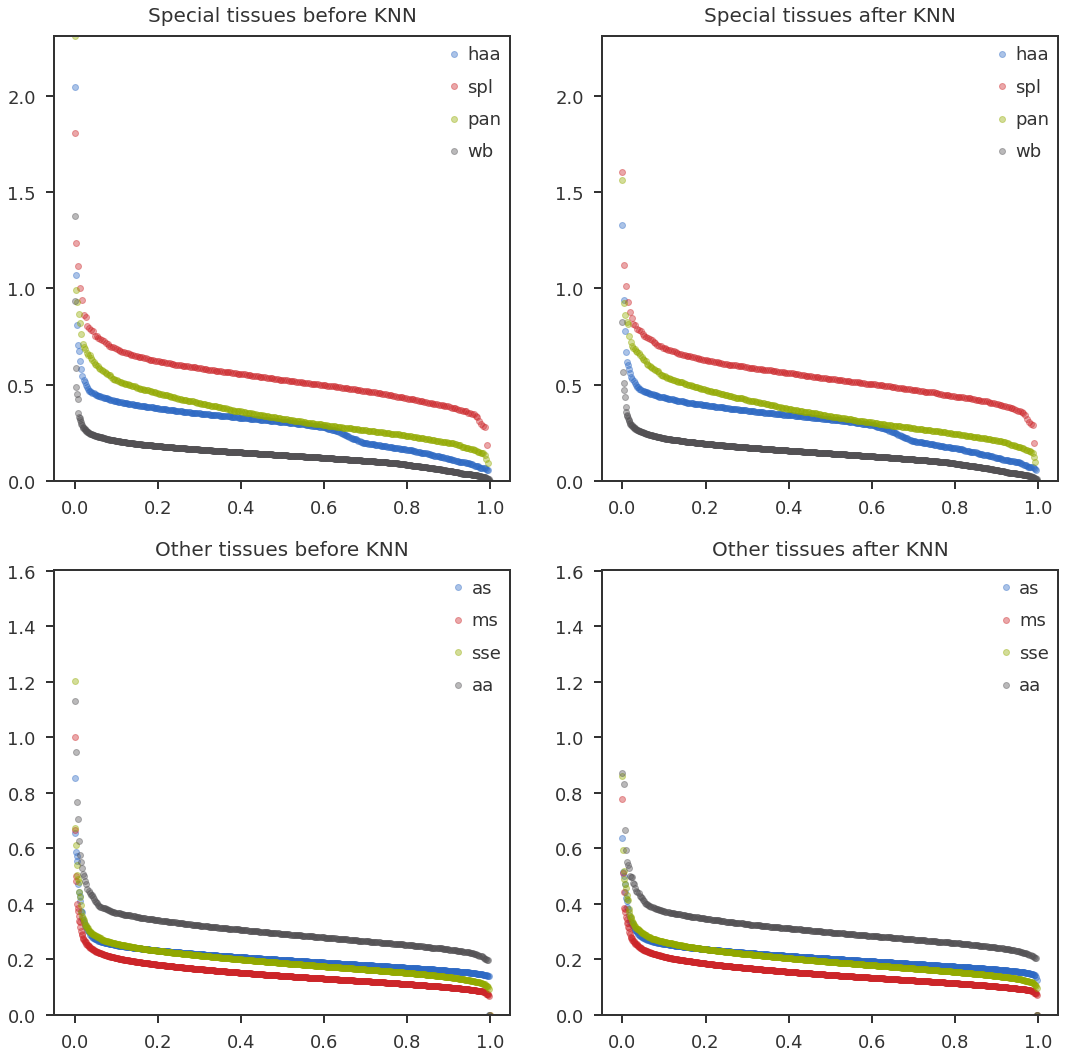

In [35]:
select_tissues = ["as", "ms", "sse", "aa"]
special_tissues = ["haa", "spl", "pan", "wb"]

f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 20)

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

m1=0
M1=0
m2=0
M2=0

for tissue in select_tissues+special_tissues:
    print(f"Loading gx {tissue}")
    df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t") #tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    ngene, nsample = df.shape
    gx_donors = list(df.columns)
    gx = df.values
    gene_names = list(df.index)
   
    gx_norm = normalize_expr( gx )

    fake_dosage = np.random.random((100, gx_norm.shape[1]))
    ## --- Apply KNN correction
    f=1
    gx_knn, gt_knn = knn_correction(gx_norm.T, fake_dosage, K=30, f=f)

    gx_knn_norm = normalize_expr(gx_knn.T)
    Y = gx_knn_norm # / np.sqrt(nsample)
    Yt = Y.T
    print(f"Tissue: {tissue}")
    
    U_knn, S_knn, Vt_knn = np.linalg.svd(Yt, full_matrices=False)
    U_0, S_0, Vt_0 = np.linalg.svd(gx_norm.T, full_matrices=False)
        
    normS_knn =  S_knn/len(S_knn)
    normX_knn =  np.arange(len(S_knn))/len(S_knn)
    
    normS_0 =  S_0/len(S_0)
    normX_0 =  np.arange(len(S_0))/len(S_0)
    
    if np.max(normS_0) > M1:
        M1 = np.max(normS_0)
    if np.max(normS_knn) > M2:
        M2 = np.max(normS_knn
                   )
    if np.min(normS_0) < m1:
        m1 = min(np.min(normS_0))
    if np.min(normS_knn) < m2:
        m2 = np.min(normS_knn)
        
    if tissue in special_tissues:
        ax2.scatter(normX_knn, normS_knn, label=tissue, alpha=0.4)
        ax1.scatter(normX_0, normS_0, label=tissue, alpha=0.4)
    else:
        ax4.scatter(normX_knn, normS_knn, label=tissue, alpha=0.4)
        ax3.scatter(normX_0, normS_0, label=tissue, alpha=0.4)
        
ax2.set_title("Special tissues after KNN", size=20, pad=15)
ax1.set_title("Special tissues before KNN", size=20, pad=15)

ax4.set_title("Other tissues after KNN", size=20, pad=15)
ax3.set_title("Other tissues before KNN", size=20, pad=15)
    
ax1.set_ylim(m1, M1)
ax2.set_ylim(m1, M1)
ax3.set_ylim(m2, M2)
ax4.set_ylim(m2, M2)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig("optim_tissues_spectrum_before_and_after_KNN.png", dpi=300, bbox_inches='tight')
plt.show()

Loading gx haa
Tissue: haa


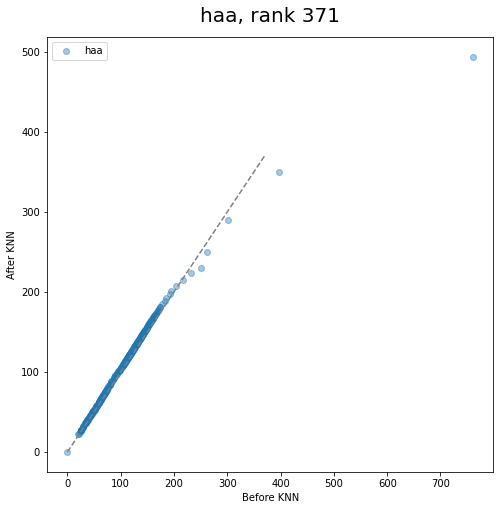

Loading gx spl
Tissue: spl


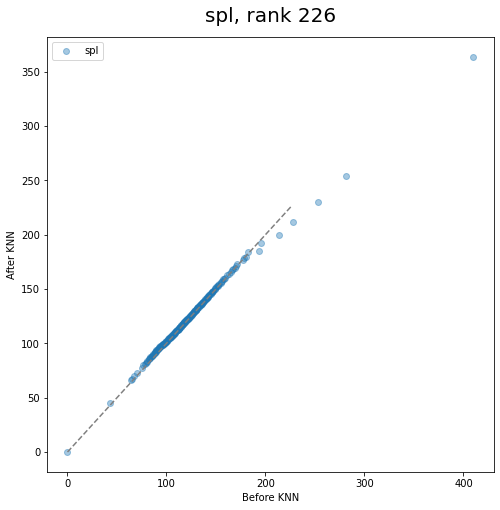

Loading gx pan
Tissue: pan


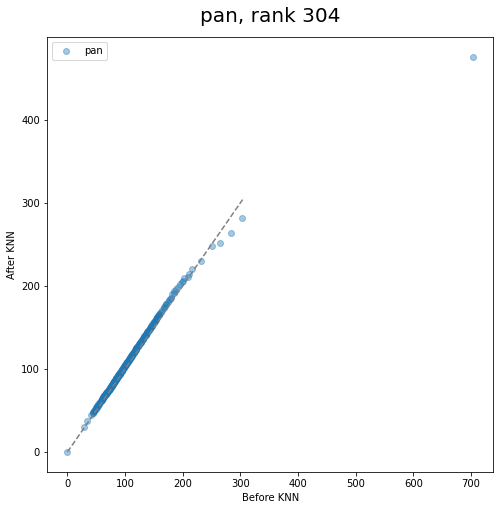

Loading gx wb
Tissue: wb


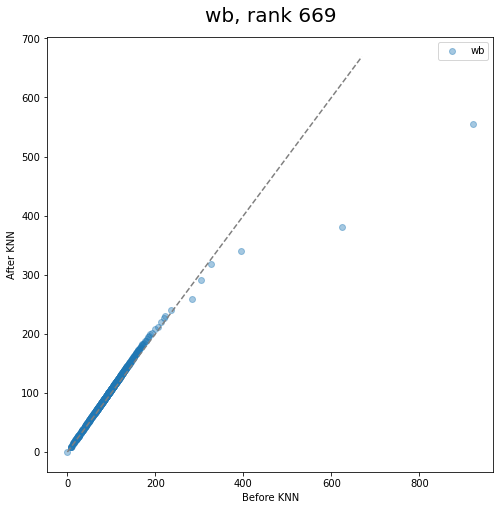

In [29]:
special_tissues = ["haa", "spl", "pan", "wb"]

f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 20)

for tissue in special_tissues:
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    print(f"Loading gx {tissue}")
    df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t") #tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    ngene, nsample = df.shape
    gx_donors = list(df.columns)
    gx = df.values
    gene_names = list(df.index)
   
    gx_norm = normalize_expr( gx )

    fake_dosage = np.random.random((100, gx_norm.shape[1]))
    ## --- Apply KNN correction
    f=1
    gx_knn, gt_knn = knn_correction(gx_norm.T, fake_dosage, K=30, f=f)

    gx_knn_norm = normalize_expr(gx_knn.T)
    Y = gx_knn_norm # / np.sqrt(nsample)
    Yt = Y.T
    print(f"Tissue: {tissue}")
    
    myrank = np.linalg.matrix_rank(Yt)
    
    U_knn, S_knn, Vt_knn = np.linalg.svd(Yt, full_matrices=False)
    U_0, S_0, Vt_0 = np.linalg.svd(gx_norm.T, full_matrices=False)
        
#     normS_knn =  S_knn/len(S_knn)
#     normX_knn =  np.arange(len(S_knn))/len(S_knn)
    
#     normS_0 =  S_0/len(S_0)
#     normX_0 =  np.arange(len(S_0))/len(S_0)
    
    ax1.scatter(S_0, S_knn, label=tissue, alpha=0.4)
    ax1.plot([0, myrank],[0,myrank], linestyle="dashed", color="grey")    
    ax1.set_title(f"{tissue}, rank {myrank}", size=20, pad=15)
    ax1.set_xlabel("Before KNN")
    ax1.set_ylabel("After KNN")
    ax1.legend()
    plt.savefig(f"{tissue}_singular_values_KNN.png", dpi=150, bbox_inches='tight')
    plt.show()

## SVD spectrum with and without normalization

../../utils/mpl_stylesheet.py:28: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\usepackage{microtype}',


Loading gx as
Tissue: as
Loading gx ms
Tissue: ms
Loading gx sse
Tissue: sse
Loading gx aa
Tissue: aa
Loading gx haa
Tissue: haa
Loading gx spl
Tissue: spl
Loading gx pan
Tissue: pan
Loading gx wb
Tissue: wb


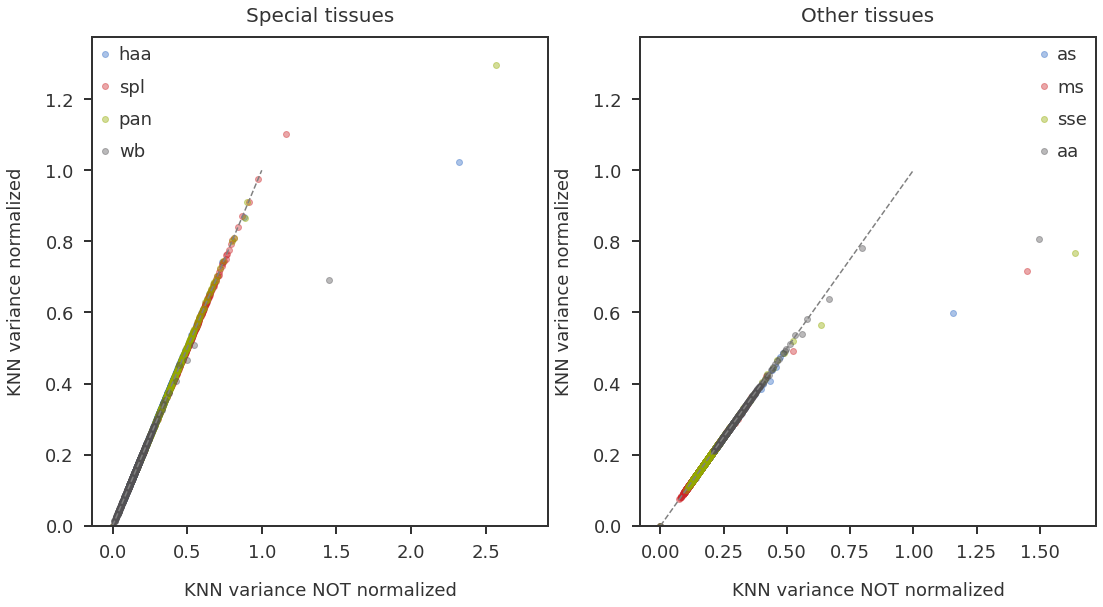

In [34]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

select_tissues = ["as", "ms", "sse", "aa"]
special_tissues = ["haa", "spl", "pan", "wb"]

f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 20)

fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


m=0
M=0

for tissue in select_tissues+special_tissues:
    print(f"Loading gx {tissue}")
    df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_knn30_norm.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t") #tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    ngene, nsample = df.shape
    gx_donors = list(df.columns)
    gx = df.values
    gene_names = list(df.index)
   
    gx_norm = normalize_expr( gx )

    fake_dosage = np.random.random((100, gx_norm.shape[1]))  ## this is not used at all!!
    ## --- Apply KNN correction
    f=1
    gx_knn, gt_knn = knn_correction(gx_norm.T, fake_dosage, K=30, f=f)

    gx_knn_norm = normalize_expr(gx_knn.T)
    Y = gx_knn_norm # / np.sqrt(nsample)
    Yt = Y.T
    print(f"Tissue: {tissue}")
    
    U_knn_norm, S_knn_norm, Vt_knn_norm = np.linalg.svd(Yt, full_matrices=False)
    U_knn, S_knn, Vt_knn                = np.linalg.svd(gx_knn.T, full_matrices=False)
        
    normS_knn =  S_knn/len(S_knn)
    normX_knn =  np.arange(len(S_knn))/len(S_knn)
    
    normS_knn_norm =  S_knn_norm/len(S_knn_norm)
    normX_knn_norm =  np.arange(len(S_knn_norm))/len(S_knn_norm)
    
    if np.max(normS_0) > M:
        M = max(np.max(normS_0), np.max(normS_knn))
    if np.min(normS_0) < m:
        m = min(np.min(normS_0), np.min(normS_knn))
        
    if tissue in special_tissues:
        ax1.scatter(normS_knn, normS_knn_norm, label=tissue, alpha=0.4)
    else:
        ax2.scatter(normS_knn, normS_knn_norm, label=tissue, alpha=0.4)

ax1.plot([0, 1],[0, 1], linestyle="dashed", color="grey")    
ax2.plot([0, 1],[0, 1], linestyle="dashed", color="grey")    

ax1.set_title("Special tissues", size=20, pad=15)
ax2.set_title("Other tissues", size=20, pad=15)
ax1.set_ylabel("KNN variance normalized")
ax2.set_ylabel("KNN variance normalized")
ax1.set_xlabel("KNN variance NOT normalized")
ax2.set_xlabel("KNN variance NOT normalized")
    
ax1.set_ylim(m, M)
ax2.set_ylim(m, M)
ax3.set_ylim(m, M)
ax4.set_ylim(m, M)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig(f"tissues_singular_values_with_and_without_var_norm.png", dpi=150, bbox_inches='tight')
plt.show()

# SVD spectrum with sbeta and sigmax

Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 0 SNPs because of low MAF (current)
Tissue: as
Q:546.7561144730495 | sx2:0.02992978717591454 | sb2:3.6e-05 | Keff:546.1409346983936 | Rank:580
Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 1 SNPs because of low MAF (current)
Tissue: ms
Q:647.2543648594923 | sx2:0.030497665586844542 | sb2:3.6e-05 | Keff:646.8372685935789 | Rank:705
Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 1 SNPs because of low MAF (current)
Tissue: sse
Q:572.5725330395353 | sx2:0.025894721823797713 | sb2:3.6e-05 | Keff:570.4291696388532 | Rank

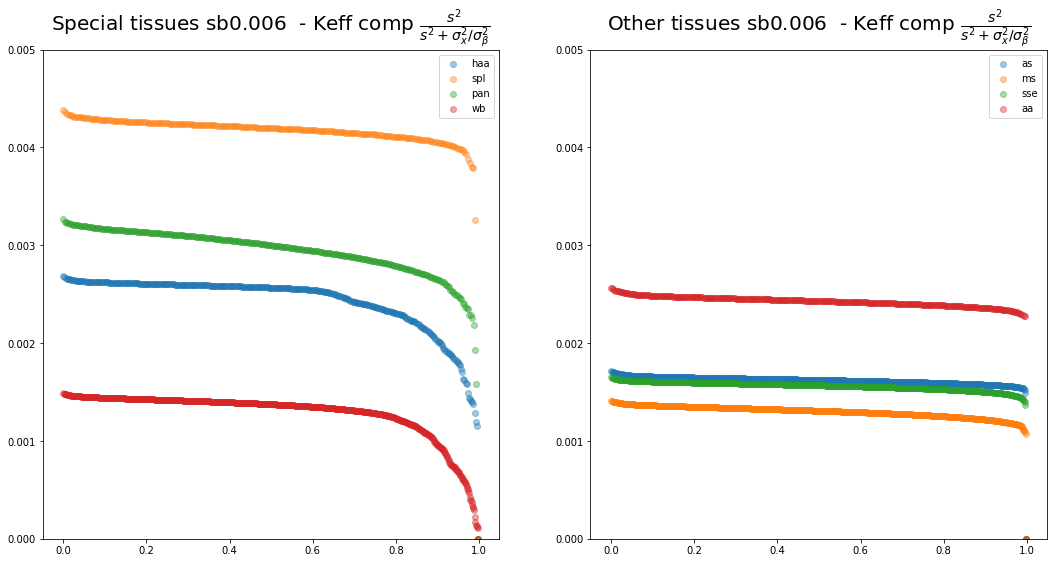

In [31]:
select_tissues = ["as", "ms", "sse", "aa"]
special_tissues = ["haa", "spl", "pan", "wb"]

f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 20)

fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for tissue in select_tissues+special_tissues:
    df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
    ngene, nsample = df.shape
    gx_donors = list(df.columns)
    gx = df.values
    gene_names = list(df.index)
    
    vcfmask, exprmask = select_donors(gt_donors, gx_donors)
    genes, indices = select_genes(geneinfo, gene_names)
    dosage_masked = gtfull[:, vcfmask]

    snp_info, dosage = filter_snps(snpinfos, dosage_masked)

    gx_norm = normalize_expr( gx[:, exprmask] )

    ## --- Apply KNN correction
    f=1
    gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

    ## --- Normalize GX and GT
    gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
    sigmax2     = np.var(gt_cent, axis = 1)

    gx_knn_norm = normalize_expr(gx_knn.T)
    gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
    sigmax2_knn = np.var(gt_knn_cent, axis = 1)
    
    Y = gx_knn_norm # / np.sqrt(nsample)
    Yt = Y.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    rank = np.linalg.matrix_rank(Yt)
    
    # sb2 = optimize_sb2(S=S, sigmasx=sigmax2_knn, target=0.9)
    sbeta = 0.006
    if tissue in special_tissues:
        sb2 = np.square(np.repeat(sbeta, dosage.shape[0]))
    else:
        sb2 = np.square(np.repeat(sbeta, dosage.shape[0]))
    
    i = 0
    S2 = np.square(S)
    S2mod = S2 + (sigmax2_knn[i] / sb2[i])
    Keff_comp = S2/S2mod

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2_knn[i]
    Rscore = np.sum(np.square(np.dot(U.T, gt_knn_cent[i,:])) * (S2 / S2mod)) / sigmax2_knn[i]
    print(f"Tissue: {tissue}")
    print(f"Q:{Rscore} | sx2:{sigmax2_knn[i]} | sb2:{sb2[i]} | Keff:{np.sum(Keff_comp)} | Rank:{rank}")
    
    if tissue in special_tissues:
        ax1.scatter(np.arange(len(Keff_comp))/len(Keff_comp), Keff_comp/len(Keff_comp), label=tissue, alpha=0.4)
    else:
        ax2.scatter(np.arange(len(Keff_comp))/len(Keff_comp), Keff_comp/len(Keff_comp), label=tissue, alpha=0.4)
        
    ax1.set_title(f"Special tissues sb{sbeta} "+r" - Keff comp $\frac{s^2}{s^2 +\sigma^2_{x}/\sigma^2_{\beta}}$", size=20, pad=15)
    ax2.set_title(f"Other tissues sb{sbeta} "+r" - Keff comp $\frac{s^2}{s^2 +\sigma^2_{x}/\sigma^2_{\beta}}$", size=20, pad=15)
    
ax1.set_ylim(0,0.005)
ax2.set_ylim(0,0.005)
ax1.legend()
ax2.legend()
plt.show()